In [11]:
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, Reshape, Input, Embedding, LSTM, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.utils  import to_categorical
from datetime     import datetime
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [12]:
data_dir = 'numpy_arrays'
X  = 'train_picture_features.npy'
y  = 'train_picture_labels.npy'

train_features = np.load(os.path.join(data_dir, X))
train_labels   = np.load(os.path.join(data_dir, y))

print("Features:",train_features.shape)
print("Labels", train_labels.shape)

Features: (33402,)
Labels (33402,)


In [13]:
# Preprocessing features
from skimage.transform import resize

%matplotlib inline

def resize_images(arrays, side_length):
    
    array_count = arrays.shape[0]
    template    = np.zeros((side_length, side_length,3))
    all_arrays = []
    
    for array in arrays:
        
        #print(array.shape)
        height, width = array.shape[0], array.shape[1]
        if height > width:
            new_height = side_length
            diff       = side_length / height
            new_width  = width * diff
        else:
            new_width  = side_length
            diff       = side_length / width
            new_height = height * diff
            
            tmp            = resize(array, (int(new_height), int(new_width), 3), mode='constant')
            top_padding    = np.zeros((int((side_length - tmp.shape[0]) / 2), side_length, 3))
            bottom_padding = np.zeros((int(side_length - top_padding.shape[0] - tmp.shape[0]) , side_length, 3))
 
            #print(top_padding.shape)
            #print(tmp.shape)
            #print(bottom_padding.shape)
            final = np.concatenate((top_padding, tmp, bottom_padding))
            #print(final.shape)
        
        all_arrays.append(final)
    
    return np.array(all_arrays)

def crop(arrays, new_width):
    ratio_max = 0.0
    ratio_min = np.inf
    
    for i, array in enumerate(arrays):
        print(array.shape)
        if i > 20:
            break
        height, width = array.shape[0], array.shape[1]
        ratio = height / (1.0 * width)
        ratio_max = max(ratio_max, ratio)
        ratio_min = min(ratio_min, ratio)

    print("MAX: ", ratio_max)
    print("MIN: ", ratio_min)
#################################

def resize_32x32(features):
    return np.array([resize(f, (32, 32, 3), mode='constant') for f in features])

def resize_32x32_grey(features):
    return np.array([resize(f, (32, 32, 1), mode='constant') for f in features])

def resize_64x64(features):
    return np.array([resize(f, (64, 64, 3), mode='constant') for f in features])

resized_images = resize_32x32(train_features)

print(resized_images.shape)
print(type(resized_images))

(33402, 32, 32, 3)
<class 'numpy.ndarray'>


In [14]:
# Preprocessing targets

def list_to_arrays(labels):
    return np.array([np.array(label) for label in labels])

def remove_val(labels, in_val, out_val):
    for label in labels:
        label[label == in_val] = out_val
    
    return labels
    #return np.where(labels==in_val, out_val, labels) 

def pad_labels(train_labels):
    print(train_labels.shape)
    max_len = 0
    
    for arr in train_labels:
        max_len = max(len(arr), max_len)

    print("MAX LENGTH: {}".format(max_len))
    
    return np.array([arr + ((max_len - len(arr)) * [10.0]) for arr in train_labels])     

def one_hot_encoding(labels):
    return np.array([ to_categorical(label, num_classes=11) for label in labels])


train_labels[24] = [6.0, 0.0, 1.0]
print(train_labels[24])
print(train_labels.shape)

padded_labels = pad_labels(train_labels)
print(padded_labels[24])
print(padded_labels.shape)

encoded_labels = one_hot_encoding(padded_labels)
print(encoded_labels[24])
print(encoded_labels.shape)

[6.0, 0.0, 1.0]
(33402,)
(33402,)
MAX LENGTH: 6
[  6.   0.   1.  10.  10.  10.]
(33402, 6)
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
(33402, 6, 11)


In [15]:
#encoded_labels[:, 6]
tmp = [encoded_labels[:, i] for i in range(encoded_labels.shape[1])]
type(tmp)

#print(padded_labels[0])
#print(encoded_labels[0])
#print(padded_labels[1])
#print(encoded_labels[1])

#tmp = [label[j] for label in encoded_labels for j in range(len(label))]
reordered_array = []
for i in range(encoded_labels.shape[1]):
    tmp = []

    for label in encoded_labels:
        #print(label[i])

        tmp.append(label[i])
    tmp = np.array(tmp)
    reordered_array.append(tmp)
reordered_array = np.array(reordered_array)

print(reordered_array.shape)
#tmp = [i for i in reordered_array]
#print(tmp.shape)

(6, 33402, 11)


In [16]:
features = resized_images
targets = [encoded_labels[:, i] for i in range(6)]
#targets = encoded_labels
#targets = padded_labels
#targets = reordered_array

print("INPUT SHAPE: {}".format(features.shape))

inputs_ = Input(shape=(32,32,3))
x = inputs_

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x) 
x = Dropout(0.25)(x)
"""
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x) 
x = Dropout(0.25)(x)

x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x) 
x = Dropout(0.25)(x)

x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x) 
x = Dropout(0.25)(x)
"""
###########################################
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
x = Dense(512, activation='relu')(x)

digit1 = Dense(11, activation='softmax')(x)
digit2 = Dense(11, activation='softmax')(x)
digit3 = Dense(11, activation='softmax')(x)
digit4 = Dense(11, activation='softmax')(x)
digit5 = Dense(11, activation='softmax')(x)
digit6 = Dense(11, activation='softmax')(x)

model = Model(input=inputs_, outputs=[digit1, digit2, digit3, digit4, digit5, digit6])
model.summary()

INPUT SHAPE: (33402, 32, 32, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 32, 32)    896                                          
____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (None, 32, 32, 32)    128                                          
____________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)   (None, 16, 16, 32)    0                                            
___________________________________________________________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint

epochs     = 10
time_now   = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join('models', 'model_multi_ModelAPI_' + str(epochs) + 'epochs_' + time_now +'.hdf5')

print("MODEL FILE: {}".format(model_path))

checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, save_best_only=False, monitor='acc',)

model.fit(features, targets,
          validation_split=0.25,
          epochs=epochs, 
          batch_size=32, 
          callbacks=[checkpointer], 
          verbose=1)


MODEL FILE: models/model_multi_ModelAPI_10epochs_20190703_205607.hdf5
Train on 25051 samples, validate on 8351 samples
Epoch 1/10
25051/25051 [==============================] - 80s - loss: 5.7912 - dense_9_loss: 2.0552 - dense_10_loss: 2.2270 - dense_11_loss: 1.1894 - dense_12_loss: 0.2705 - dense_13_loss: 0.0249 - dense_14_loss: 0.0241 - dense_9_acc: 0.2665 - dense_10_acc: 0.2491 - dense_11_acc: 0.7332 - dense_12_acc: 0.9621 - dense_13_acc: 0.9985 - dense_14_acc: 0.9984 - val_loss: 5.7157 - val_dense_9_loss: 2.0388 - val_dense_10_loss: 2.2392 - val_dense_11_loss: 1.1826 - val_dense_12_loss: 0.2474 - val_dense_13_loss: 0.0058 - val_dense_14_loss: 0.0019 - val_dense_9_acc: 0.2711 - val_dense_10_acc: 0.2048 - val_dense_11_acc: 0.7358 - val_dense_12_acc: 0.9632 - val_dense_13_acc: 0.9996 - val_dense_14_acc: 0.9999
Epoch 2/10
25051/25051 [==============================] - 79s - loss: 5.6990 - dense_9_loss: 2.0587 - dense_10_loss: 2.2299 - dense_11_loss: 1.1591 - dense_12_loss: 0.2475 - den

25051/25051 [==============================] - 79s - loss: 11.5575 - dense_9_loss: 4.1195 - dense_10_loss: 4.4491 - dense_11_loss: 2.5132 - dense_12_loss: 0.4718 - dense_13_loss: 0.0039 - dense_14_loss: 1.7015e-07 - dense_9_acc: 0.2187 - dense_10_acc: 0.1944 - dense_11_acc: 0.6815 - dense_12_acc: 0.9633 - dense_13_acc: 0.9998 - dense_14_acc: 1.0000 - val_loss: 10.3823 - val_dense_9_loss: 3.0219 - val_dense_10_loss: 4.4275 - val_dense_11_loss: 2.4568 - val_dense_12_loss: 0.4684 - val_dense_13_loss: 0.0058 - val_dense_14_loss: 0.0019 - val_dense_9_acc: 0.2712 - val_dense_10_acc: 0.2457 - val_dense_11_acc: 0.7358 - val_dense_12_acc: 0.9632 - val_dense_13_acc: 0.9996 - val_dense_14_acc: 0.9999
Epoch 9/10
25051/25051 [==============================] - 80s - loss: 11.9098 - dense_9_loss: 4.3498 - dense_10_loss: 4.6580 - dense_11_loss: 2.4450 - dense_12_loss: 0.4531 - dense_13_loss: 0.0039 - dense_14_loss: 1.2387e-07 - dense_9_acc: 0.2215 - dense_10_acc: 0.2021 - dense_11_acc: 0.6924 - dense_

PREDICTION0: [  2.  10.  10.  10.  10.  10.]
PREDICTION1: [  2.  10.  10.  10.  10.  10.]
PREDICTION2: [  1.  10.  10.  10.  10.  10.]
PREDICTION3: [  2.  10.  10.  10.  10.  10.]
PREDICTION4: [  1.  10.  10.  10.  10.  10.]
LABEL0: [  1.   9.  10.  10.  10.  10.]
LABEL1: [  2.   3.  10.  10.  10.  10.]
LABEL2: [  2.   5.  10.  10.  10.  10.]
LABEL3: [  9.   3.  10.  10.  10.  10.]
LABEL4: [  3.   1.  10.  10.  10.  10.]


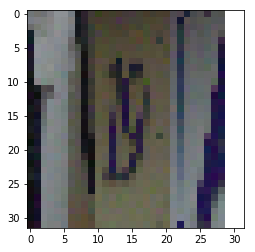

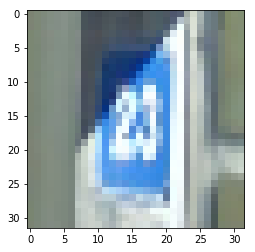

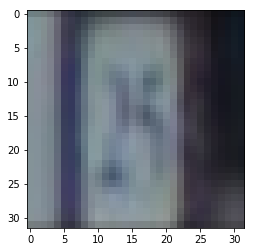

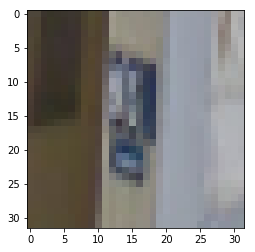

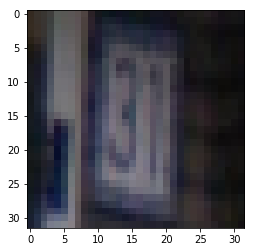

In [18]:
# TESTING

def predict(model, array):
    y_pred = model.predict(array)
    y_pred = np.array(y_pred)

    entries = [y_pred[:, i, :] for i in range(y_pred.shape[1])]
    
    all_digits = []
    for entry in entries:
        
        entry_digits = []
        for digit in entry:
            entry_digits.append(np.argmax(digit))

        all_digits.append(entry_digits)
   
    return np.array(all_digits).astype('float64')
    
test_set    = resized_images[:5]
predictions = predict(model, test_set)

for i, prediction in enumerate(predictions):
    print("PREDICTION{}: {}".format(i, prediction))

for i, num in enumerate(test_set):
    print("LABEL{}: {}".format(i, padded_labels[i]))

for img in test_set:
    fig,ax  = plt.subplots(1)
    ax.imshow(img)

In [19]:

def get_accuracy(predictions, labels):
    correct = 0
    for i, pred in enumerate(predictions):
        pred_str  = "".join([str(p) for p in pred if p != 10])
        label_str = "".join([str(int(j)) for j in labels[i]])
        #print(pred_str, label_str)
        if pred_str == label_str:
            correct += 1
    return (correct*1.0) / len(predictions)

In [20]:
# Testing
test_features = np.load(os.path.join(data_dir, 'test_picture_features.npy'))
test_labels   = np.load(os.path.join(data_dir, 'test_picture_labels.npy'))

In [21]:
resized_test_images = resize_32x32(test_features)

In [22]:
test_predictions = predict(model, resized_test_images)

In [23]:
print("Accuracy: {}".format(get_accuracy(test_predictions, test_labels)*100))

Accuracy: 0.0


In [24]:
sample = 10
print(test_predictions[sample])
print(test_labels[sample])

[  2.  10.  10.  10.  10.  10.]
[3.0, 4.0]


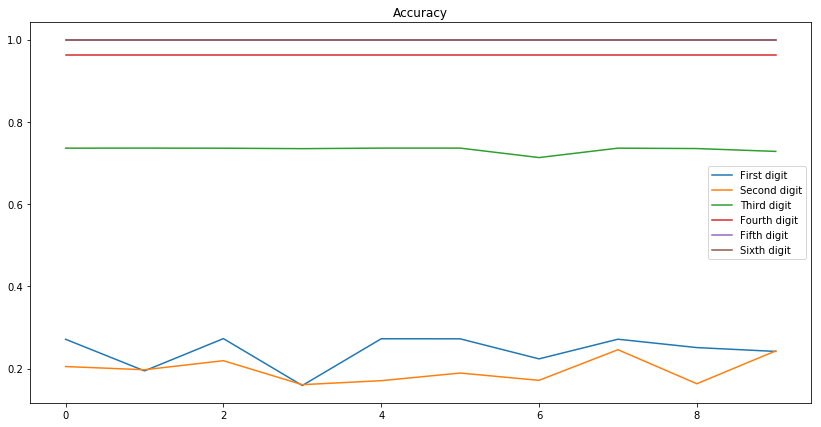

In [26]:
%matplotlib inline
plt.figure(figsize=(14, 7))

plt.plot(model.history.history['val_dense_9_acc'], label='First digit')
plt.plot(model.history.history['val_dense_10_acc'], label='Second digit')
plt.plot(model.history.history['val_dense_11_acc'], label='Third digit')
plt.plot(model.history.history['val_dense_12_acc'], label='Fourth digit')
plt.plot(model.history.history['val_dense_13_acc'], label='Fifth digit')
plt.plot(model.history.history['val_dense_14_acc'], label='Sixth digit')

plt.legend()
plt.title('Accuracy')
plt.show()

In [39]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(features[0].reshape(1,32,32,3))

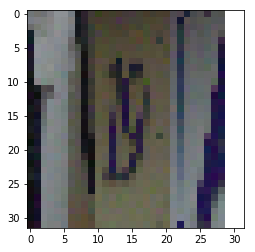

In [51]:
plt.imshow(features[0]);

In [48]:
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index])
            activation_index += 1

IndexError: index 32 is out of bounds for axis 3 with size 32

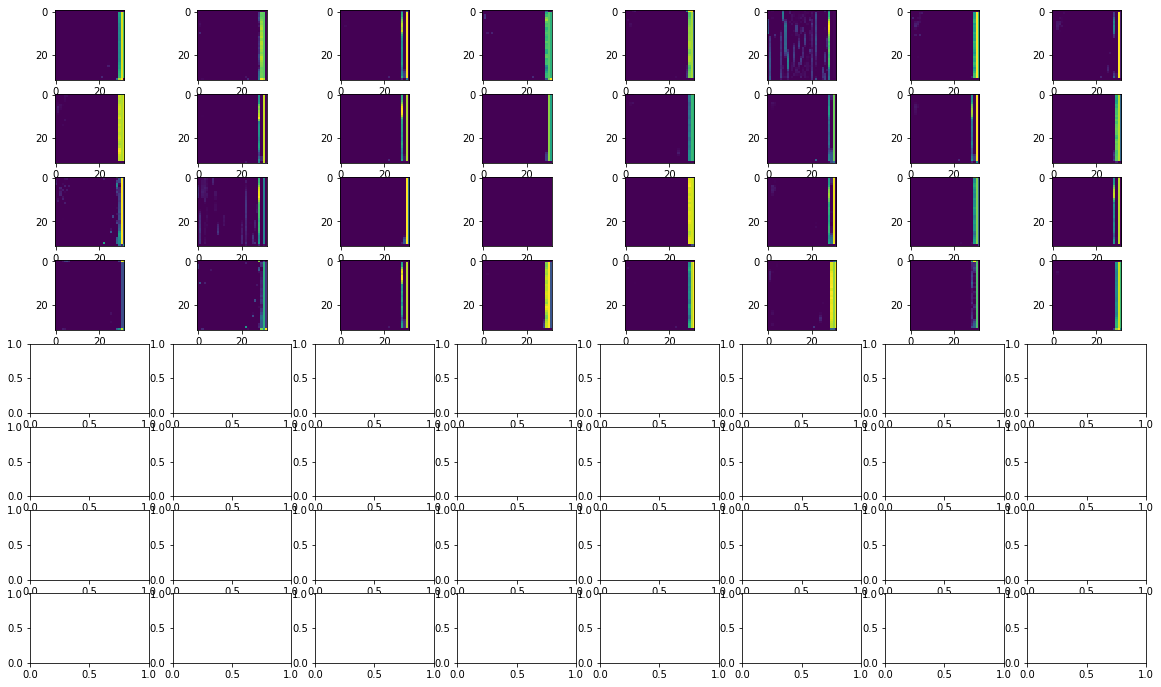

In [54]:
display_activation(activations, 8, 8, 1)